<h1 align=center><font size = 5>Identifying Suitable Areas for a Cycle Shop in London</font></h1>
<h2 align=center><font size = 5>Part 3 - K-Means Modelling</font></h2>

## Introduction

In this final notebook we have been asked to use K-means modelling to cluster our data and identify the most ideal location(s) to set up a new cycle shop

## Notebook Setup


In [3]:
import pandas as pd 
import collections

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing


In [4]:
dfLondon = pd.read_csv('dfLondon.csv')

dfLondon.head(10)

,Borough,Area,Population,Radius,Open Routes,In Progress Routes,Planned Routes,Total Routes,Shop Count,Route/Shop Ratio,Pop Density
0,Barking and Dagenham,13.93,194352,3242.808799,64,10,23,97,2,48.50,13952.05
1,Barnet,33.49,369088,5028.093653,0,0,0,0,9,0.00,11020.84
2,Bexley,23.38,236687,4201.148547,0,589,0,589,5,117.80,10123.48
3,Brent,16.70,317264,3550.618569,426,5,0,431,3,143.67,18997.84
4,Bromley,57.97,317899,6615.267871,0,286,413,699,2,349.50,5483.85
5,Camden,8.40,229719,2518.172214,753,223,235,1211,26,46.58,27347.50
6,Croydon,33.41,372752,5022.084576,89,0,174,263,4,65.75,11156.90
7,Ealing,21.44,342494,4023.075426,628,565,36,1229,6,204.83,15974.53
8,Enfield,31.74,320524,4894.961110,997,798,0,1795,2,897.50,10098.42
9,Greenwich,18.28,264008,3714.786685,0,69,0,69,4,17.25,14442.45


## Build a K-means model
Let's try a few K values first then we can pick the best one.  It seems that it's most important to start a shop where we have the most cycle routes per shop and people and so I will use population density and the Route/Shop ratio.

,K,Silhouette,Harabasz,Model Split
0,2,0.439502,23.299527,"(19, 13)"
1,3,0.470472,30.123481,"(17, 13, 2)"
2,4,0.462854,33.466531,"(17, 8, 1, 6)"
3,5,0.394525,34.062308,"(11, 6, 8, 1, 6)"
4,6,0.430885,39.098850,"(11, 7, 5, 1, 6, 2)"
5,7,0.459703,45.587676,"(11, 7, 5, 1, 2, 4, 2)"
6,8,0.427926,48.147259,"(10, 6, 1, 6, 1, 2, 4, 2)"
7,9,0.393857,48.439280,"(7, 6, 1, 6, 1, 2, 3, 4, 2)"
8,10,0.372135,50.879668,"(7, 6, 1, 4, 1, 2, 3, 4, 2, 2)"
9,11,0.379371,56.219002,"(8, 2, 1, 5, 4, 1, 2, 3, 2, 2, 2)"


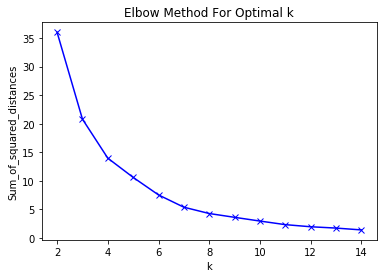

In [6]:
# set number of clusters
K = range(2,15)
metricScoresDf = pd.DataFrame(columns=('K','Silhouette', ' Harabasz'))

#\X_train = dfLondon[['Density', 'Total Routes','Shop Count']]
X_train = dfLondon[['Pop Density','Route/Shop Ratio']]

x = X_train.values #returns a numpy array
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
dfLondon_clustering=pd.DataFrame(x_scaled, columns=X_train.columns)

# run k-means clustering
Sum_of_squared_distances = []
for k in K:
    k_means = KMeans(n_clusters=k, random_state = 0)
    model = k_means.fit(dfLondon_clustering)
    Sum_of_squared_distances.append(k_means.inertia_)
    y_hat = k_means.predict(dfLondon_clustering)
    labels = k_means.labels_
    if k != 1:
        silhouette = metrics.silhouette_score(dfLondon_clustering, labels, metric = 'euclidean')
        harabasz = metrics.calinski_harabasz_score(dfLondon_clustering, labels)
        modelSplit = collections.Counter(model.labels_).values()
        metricScoresDf = metricScoresDf.append({'K':k,'Silhouette':silhouette, ' Harabasz':harabasz, 'Model Split':modelSplit}, ignore_index = True)

display(metricScoresDf)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10] 

Looking at the graph I would like to choose a K between 6 and 10.  The silhouette score is strong at K = 7 so we will continue with this.

In [7]:
k_means = KMeans(n_clusters=7, random_state = 0)
model = k_means.fit(dfLondon_clustering)
# check cluster labels generated for each row in the dataframe
collections.Counter(model.labels_).values()

dict_values([11, 7, 5, 1, 2, 4, 2])

Add the labels into our dfLondon dataframe

In [8]:
#dfLondon = dfLondon.drop('Cluster Labels', 1)
dfLondon.insert(0, 'Cluster Labels', model.labels_)

Let's view our clusters.

In [9]:

for i in sorted(dfLondon['Cluster Labels'].unique()):
    display(dfLondon.loc[dfLondon['Cluster Labels'] == i])

#display(dfLondon.sort_values(by=['Cluster Labels']))


,Cluster Labels,Borough,Area,Population,Radius,Open Routes,In Progress Routes,Planned Routes,Total Routes,Shop Count,Route/Shop Ratio,Pop Density
3,0,Brent,16.70,317264,3550.618569,426,5,0,431,3,143.67,18997.84
5,0,Camden,8.40,229719,2518.172214,753,223,235,1211,26,46.58,27347.50
11,0,Hammersmith and Fulham,6.33,178685,2185.987325,329,77,283,689,14,49.21,28228.28
12,0,Haringey,11.42,263386,2936.154041,358,0,0,358,5,71.60,23063.57
23,0,Newham,13.98,318227,3248.623415,0,0,0,0,4,0.00,22763.02
26,0,Southwark,11.14,298464,2899.935777,1795,555,1109,3459,24,144.12,26792.10
30,0,Wandsworth,13.23,310516,3160.281047,1638,0,872,2510,12,209.17,23470.60


,Cluster Labels,Borough,Area,Population,Radius,Open Routes,In Progress Routes,Planned Routes,Total Routes,Shop Count,Route/Shop Ratio,Pop Density
8,1,Enfield,31.74,320524,4894.96111,997,798,0,1795,2,897.5,10098.42


,Cluster Labels,Borough,Area,Population,Radius,Open Routes,In Progress Routes,Planned Routes,Total Routes,Shop Count,Route/Shop Ratio,Pop Density
0,2,Barking and Dagenham,13.93,194352,3242.808799,64,10,23,97,2,48.50,13952.05
1,2,Barnet,33.49,369088,5028.093653,0,0,0,0,9,0.00,11020.84
2,2,Bexley,23.38,236687,4201.148547,0,589,0,589,5,117.80,10123.48
6,2,Croydon,33.41,372752,5022.084576,89,0,174,263,4,65.75,11156.90
9,2,Greenwich,18.28,264008,3714.786685,0,69,0,69,4,17.25,14442.45
13,2,Harrow,19.49,243372,3835.762456,0,0,0,0,2,0.00,12487.02
14,2,Havering,43.35,242080,5720.583583,0,0,0,0,4,0.00,5584.31
15,2,Hillingdon,44.67,286806,5807.025869,129,36,167,332,4,83.00,6420.55
22,2,Merton,14.52,203223,3310.770621,388,0,67,455,4,113.75,13996.07
25,2,Richmond upon Thames,22.17,191365,4090.992008,340,3,128,471,7,67.29,8631.71


,Cluster Labels,Borough,Area,Population,Radius,Open Routes,In Progress Routes,Planned Routes,Total Routes,Shop Count,Route/Shop Ratio,Pop Density
18,3,Kensington and Chelsea,4.68,155594,1879.614173,1248,70,529,1847,4,461.75,33246.58
20,3,Lambeth,10.36,314242,2796.569792,1590,362,447,2399,7,342.71,30332.24
28,3,Tower Hamlets,7.63,272890,2399.982381,1335,0,469,1804,5,360.80,35765.40
31,3,Westminster,8.29,226841,2501.629847,2388,222,1329,3939,12,328.25,27363.21


,Cluster Labels,Borough,Area,Population,Radius,Open Routes,In Progress Routes,Planned Routes,Total Routes,Shop Count,Route/Shop Ratio,Pop Density
4,4,Bromley,57.97,317899,6615.267871,0,286,413,699,2,349.50,5483.85
7,4,Ealing,21.44,342494,4023.075426,628,565,36,1229,6,204.83,15974.53
16,4,Hounslow,21.61,262407,4038.993627,0,0,881,881,4,220.25,12142.85
19,4,Kingston upon Thames,14.38,166793,3294.770945,417,891,187,1495,6,249.17,11598.96
24,4,Redbridge,21.78,288272,4054.849338,533,0,164,697,4,174.25,13235.63


,Cluster Labels,Borough,Area,Population,Radius,Open Routes,In Progress Routes,Planned Routes,Total Routes,Shop Count,Route/Shop Ratio,Pop Density
21,5,Lewisham,13.57,286180,3200.631744,409,728,137,1274,3,424.67,21089.17
29,5,Waltham Forest,14.99,265797,3363.927296,1614,0,0,1614,3,538.00,17731.62


,Cluster Labels,Borough,Area,Population,Radius,Open Routes,In Progress Routes,Planned Routes,Total Routes,Shop Count,Route/Shop Ratio,Pop Density
10,6,Hackney,7.36,257379,2357.136276,1429,0,108,1537,9,170.78,34969.97
17,6,Islington,5.74,215667,2081.621336,797,13,308,1118,9,124.22,37572.65


Let's see if we can understand these better with the mean of each cluster

In [10]:
dfM = []

for i in sorted(dfLondon['Cluster Labels'].unique()):
    entry = dfLondon.loc[dfLondon['Cluster Labels'] == i].mean()
    dfM.append(entry)

dfMean = pd.concat(dfM, axis=1)
dfMean = dfMean.transpose()
dfMean = pd.DataFrame(dfMean)
dfMean.set_index('Cluster Labels', inplace=True)


dfMean.style.background_gradient(cmap='Blues')

,Area,Population,Radius,Open Routes,In Progress Routes,Planned Routes,Total Routes,Shop Count,Route/Shop Ratio,Pop Density
Cluster Labels,,,,,,,,,,
0.0,11.6,273752,2928.54,757,122.857,357,1236.86,12.5714,94.9071,24380.4
1.0,31.74,320524,4894.96,997,798,0,1795,2,897.5,10098.4
2.0,25.7836,254513,4322.64,91.8182,64.2727,60,216.091,4.45455,48.9627,10853.4
3.0,7.74,242392,2394.45,1640.25,163.5,693.5,2497.25,7,373.377,31676.9
4.0,27.436,275573,4405.39,315.6,348.4,336.2,1000.2,4.4,239.6,11687.2
5.0,14.28,275988,3282.28,1011.5,364,68.5,1444,3,481.335,19410.4
6.0,6.55,236523,2219.38,1113,6.5,208,1327.5,9,147.5,36271.3


Clusters 1, 3 and 5 look like the ideal locations to open up a new cycle shop.  

Cluster 1 is having new routes being put in and only very few shops on average.
Cluster 3 has alot of routes in place already with lot's of new routes being planned on average.  It is relatively densely populated so there is the potential for lots of customers
Cluster 5 is having some new routes already being put in and relatively few shops for the amount of cycle routes in place.  These boroughs on average are less densely populated so marketing will need to be targeted

### Three Python Notebooks

1. Data Collection and Cleaning - https://github.com/moaeedsajid/Coursera_Capstone/blob/master/Capstone_1.ipynb
2. Exploratory Data Analysis - https://github.com/moaeedsajid/Coursera_Capstone/blob/master/Capstone_2.ipynb
3. Modelling and Results - https://github.com/moaeedsajid/Coursera_Capstone/blob/master/Capstone_3.ipynb